In [33]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

In [34]:
# --- Ganti path ini sesuai model dan seed yang ingin diplot ---
OUT_DIR = "best6_multiseed"
model_name = "lstm_best_seed3"  # contoh, bisa diganti
traj_path = os.path.join(OUT_DIR, f"{model_name}_eval_traj.pkl")

In [35]:
# --- Load trajectory ---
with open(traj_path, "rb") as f:
    trajectories = pickle.load(f)

print(f"Loaded {len(trajectories)} episodes from {traj_path}")

Loaded 10 episodes from best6_multiseed/lstm_best_seed3_eval_traj.pkl


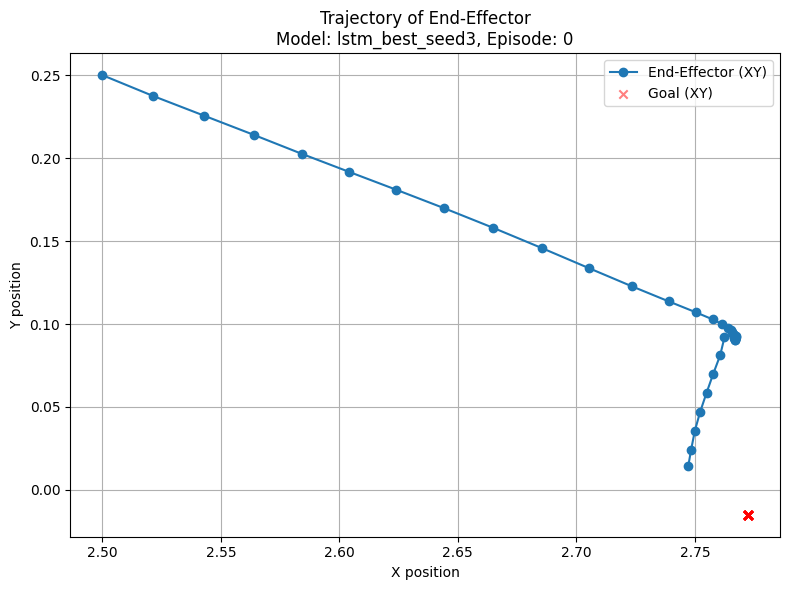

In [36]:
# --- Pilih episode yang ingin diplot ---
episode_idx = 0  # Ganti sesuai kebutuhan

traj = trajectories[episode_idx]
obs_list = traj['obs']
actions = traj['actions']
rewards = traj['rewards']
infos = traj['infos']

# --- Ambil posisi end-effector dari obs['observation'][:3] ---
ee_pos = np.array([o['observation'][:3] for o in obs_list])  # Asumsi 3D di awal
goal_pos = np.array([o['desired_goal'][:3] for o in obs_list])  # Optional, jika ingin plot goal

plt.figure(figsize=(8,6))
plt.plot(ee_pos[:, 0], ee_pos[:, 1], marker='o', label="End-Effector (XY)")
plt.scatter(goal_pos[:, 0], goal_pos[:, 1], c='r', marker='x', label="Goal (XY)", alpha=0.5)
plt.xlabel("X position")
plt.ylabel("Y position")
plt.title(f"Trajectory of End-Effector\nModel: {model_name}, Episode: {episode_idx}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


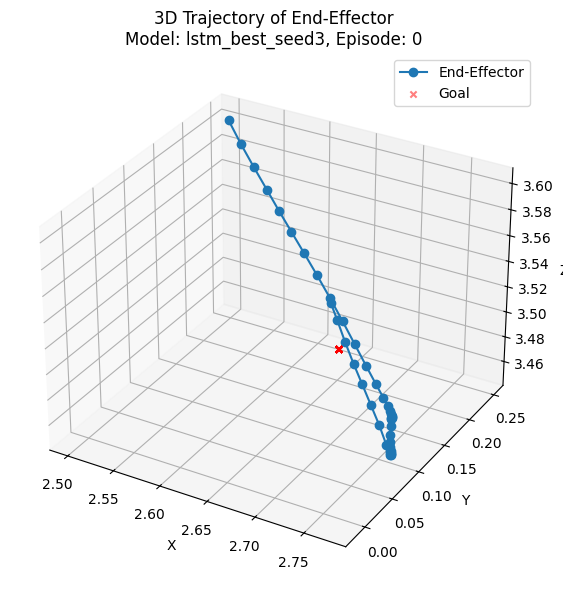

In [37]:

# --- Jika ingin plot 3D (X, Y, Z) trajectory ---
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(ee_pos[:, 0], ee_pos[:, 1], ee_pos[:, 2], marker='o', label="End-Effector")
ax.scatter(goal_pos[:, 0], goal_pos[:, 1], goal_pos[:, 2], c='r', marker='x', label="Goal", alpha=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title(f"3D Trajectory of End-Effector\nModel: {model_name}, Episode: {episode_idx}")
ax.legend()
plt.tight_layout()
plt.show()


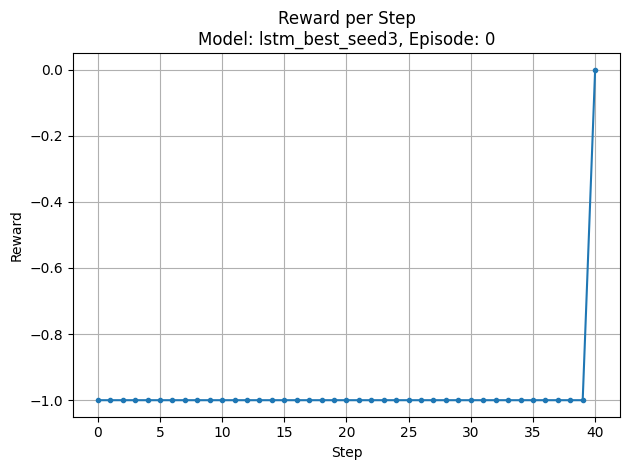

In [38]:

# --- Jika ingin plot reward per step ---
plt.figure()
plt.plot(rewards, marker='.')
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title(f"Reward per Step\nModel: {model_name}, Episode: {episode_idx}")
plt.grid(True)
plt.tight_layout()
plt.show()

Model start: [2.50000024 0.2500003  3.60099983], goal: [2.8040789  0.12033012 3.576     ]
Expert episode idx: 80, start: [2.50000024 0.2500003  3.60099983], goal: [2.79175834 0.12411275 3.576     ]
Total start+goal distance: 0.012888


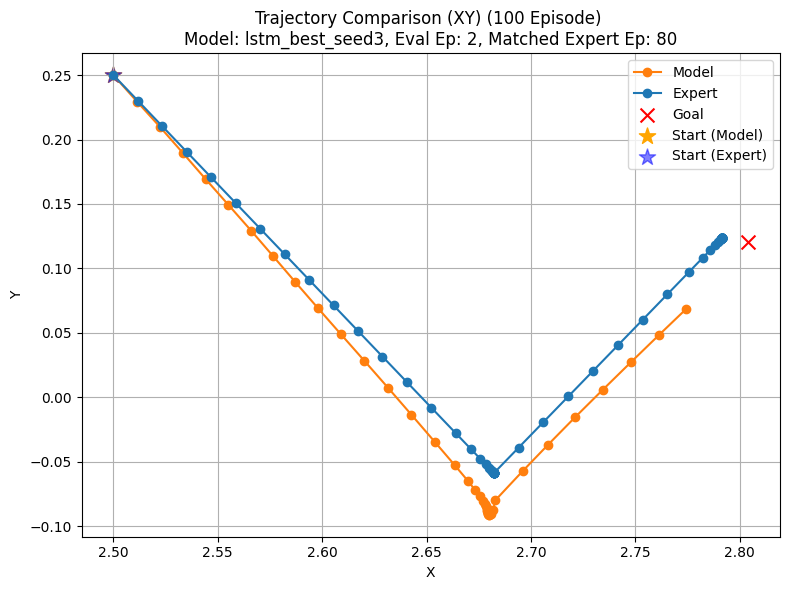

Saved XY trajectory plot to best6_multiseed/plots/lstm_best_seed3_ep2_vs_expert80_xy.png


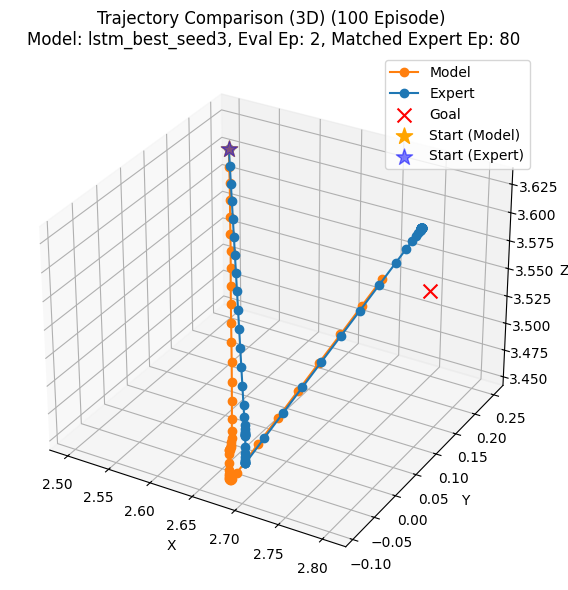

Saved 3D trajectory plot to best6_multiseed/plots/lstm_best_seed3_ep2_vs_expert80_xyz.png


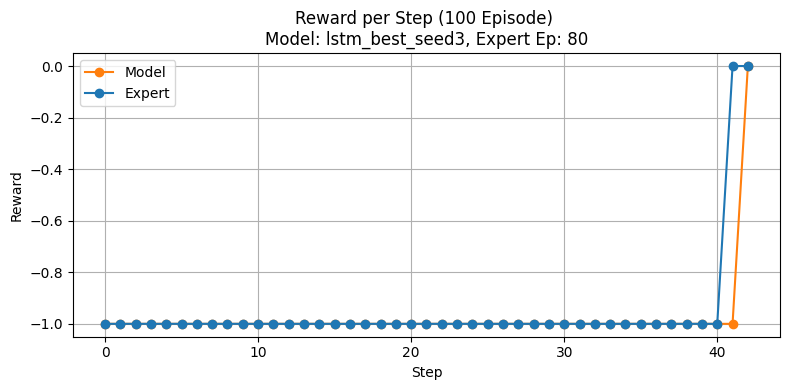

Saved reward plot to best6_multiseed/plots/lstm_best_seed3_ep2_vs_expert80_reward.png


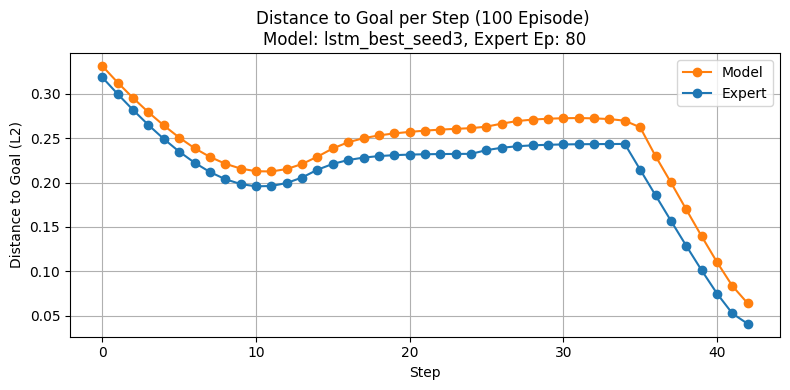

Saved distance to goal plot to best6_multiseed/plots/lstm_best_seed3_ep2_vs_expert80_dist2goal.png


In [39]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configuration ---
OUT_DIR = "best6_multiseed"
model_name = "lstm_best_seed3"  # Change as needed
model_ep_idx = 2               # Change episode index as needed

traj_path = os.path.join(OUT_DIR, f"{model_name}_eval_traj.pkl")
expert_traj_path = "expert_trajectories.pkl"

# --- Load model trajectory ---
with open(traj_path, "rb") as f:
    model_trajs = pickle.load(f)
model_ep = model_trajs[model_ep_idx]
model_obs = model_ep["obs"]
model_rewards = model_ep["rewards"]
model_ee_pos = np.array([o["observation"][:3] for o in model_obs])
model_goal = model_obs[0]["desired_goal"][:3]
model_start = model_obs[0]["observation"][:3]

# --- Load expert trajectories ---
with open(expert_traj_path, "rb") as f:
    expert_trajs = pickle.load(f)

# --- Find closest matching expert episode ---
best_idx = None
best_dist = float('inf')
for i, exp_ep in enumerate(expert_trajs):
    exp_start = exp_ep['observations'][0]['observation'][:3]
    exp_goal  = exp_ep['observations'][0]['desired_goal'][:3]
    dist = np.linalg.norm(model_start - exp_start) + np.linalg.norm(model_goal - exp_goal)
    if dist < best_dist:
        best_dist = dist
        best_idx = i
    if np.allclose(model_start, exp_start, atol=1e-4) and np.allclose(model_goal, exp_goal, atol=1e-4):
        best_idx = i
        break

# --- Prepare expert data ---
expert_ep = expert_trajs[best_idx]
expert_obs = expert_ep["observations"]
expert_rewards = expert_ep.get("rewards", None)
if expert_rewards is None:
    # Try to reconstruct reward as all 1s (success) or 0s (if missing)
    expert_rewards = [1.0 if o.get("is_success", False) else 0.0 for o in expert_obs]
expert_ee_pos = np.array([o["observation"][:3] for o in expert_obs])
expert_goal = expert_obs[0]['desired_goal'][:3]
expert_start = expert_obs[0]['observation'][:3]

print(f"Model start: {model_start}, goal: {model_goal}")
print(f"Expert episode idx: {best_idx}, start: {expert_start}, goal: {expert_goal}")
print(f"Total start+goal distance: {np.linalg.norm(model_start - expert_start) + np.linalg.norm(model_goal - expert_goal):.6f}")

# --- Ensure output directory for plots ---
plot_dir = os.path.join(OUT_DIR, "plots")
os.makedirs(plot_dir, exist_ok=True)

# --- 1. Plot XY trajectory ---
plt.figure(figsize=(8,6))
plt.plot(model_ee_pos[:,0], model_ee_pos[:,1], '-o', label="Model", color="tab:orange")
plt.plot(expert_ee_pos[:,0], expert_ee_pos[:,1], '-o', label="Expert", color="tab:blue")
plt.scatter(model_goal[0], model_goal[1], marker='x', color='red', s=100, label="Goal")
plt.scatter(model_start[0], model_start[1], marker='*', color='orange', s=150, label="Start (Model)")
plt.scatter(expert_start[0], expert_start[1], marker='*', color='blue', s=150, label="Start (Expert)", alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title(f"Trajectory Comparison (XY) (100 Episode) \nModel: {model_name}, Eval Ep: {model_ep_idx}, Matched Expert Ep: {best_idx}")
plt.grid(True)
plt.tight_layout()
xy_path = os.path.join(plot_dir, f"{model_name}_ep{model_ep_idx}_vs_expert{best_idx}_xy.png")
plt.savefig(xy_path)
plt.show()
print(f"Saved XY trajectory plot to {xy_path}")

# --- 2. Plot 3D trajectory ---
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(model_ee_pos[:,0], model_ee_pos[:,1], model_ee_pos[:,2], '-o', label="Model", color="tab:orange")
ax.plot(expert_ee_pos[:,0], expert_ee_pos[:,1], expert_ee_pos[:,2], '-o', label="Expert", color="tab:blue")
ax.scatter(model_goal[0], model_goal[1], model_goal[2], marker='x', color='red', s=100, label="Goal")
ax.scatter(model_start[0], model_start[1], model_start[2], marker='*', color='orange', s=150, label="Start (Model)")
ax.scatter(expert_start[0], expert_start[1], expert_start[2], marker='*', color='blue', s=150, label="Start (Expert)", alpha=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.set_title(f"Trajectory Comparison (3D) (100 Episode) \nModel: {model_name}, Eval Ep: {model_ep_idx}, Matched Expert Ep: {best_idx}")
plt.tight_layout()
xyz_path = os.path.join(plot_dir, f"{model_name}_ep{model_ep_idx}_vs_expert{best_idx}_xyz.png")
plt.savefig(xyz_path)
plt.show()
print(f"Saved 3D trajectory plot to {xyz_path}")

# --- 3. Plot reward per step (truncate to shortest) ---
min_len = min(len(model_rewards), len(expert_rewards))
plt.figure(figsize=(8,4))
plt.plot(range(min_len), model_rewards[:min_len], '-o', label="Model", color="tab:orange")
plt.plot(range(min_len), expert_rewards[:min_len], '-o', label="Expert", color="tab:blue")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()
plt.title(f"Reward per Step (100 Episode) \nModel: {model_name}, Expert Ep: {best_idx}")
plt.grid(True)
plt.tight_layout()
reward_path = os.path.join(plot_dir, f"{model_name}_ep{model_ep_idx}_vs_expert{best_idx}_reward.png")
plt.savefig(reward_path)
plt.show()
print(f"Saved reward plot to {reward_path}")

# --- 4. Plot distance to goal per step (L2 norm of ee_pos - goal) ---
model_dist2goal = np.linalg.norm(model_ee_pos - model_goal, axis=1)
expert_dist2goal = np.linalg.norm(expert_ee_pos - expert_goal, axis=1)
min_len = min(len(model_dist2goal), len(expert_dist2goal))
plt.figure(figsize=(8,4))
plt.plot(range(min_len), model_dist2goal[:min_len], '-o', label="Model", color="tab:orange")
plt.plot(range(min_len), expert_dist2goal[:min_len], '-o', label="Expert", color="tab:blue")
plt.xlabel("Step")
plt.ylabel("Distance to Goal (L2)")
plt.legend()
plt.title(f"Distance to Goal per Step (100 Episode) \nModel: {model_name}, Expert Ep: {best_idx}")
plt.grid(True)
plt.tight_layout()
dist_path = os.path.join(plot_dir, f"{model_name}_ep{model_ep_idx}_vs_expert{best_idx}_dist2goal.png")
plt.savefig(dist_path)
plt.show()
print(f"Saved distance to goal plot to {dist_path}")